### Import

In [2]:
import pandas as pd
import talib 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [22]:
df = pd.read_csv("./data/stocks/KO.csv", sep=',')
df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.263021,0.270182,0.263021,0.263021,0.004238,806400.0
1962-01-03,0.259115,0.259115,0.253255,0.257161,0.004143,1574400.0
1962-01-04,0.257812,0.261068,0.257812,0.259115,0.004175,844800.0
1962-01-05,0.259115,0.262370,0.252604,0.253255,0.004080,1420800.0
1962-01-08,0.251302,0.251302,0.245768,0.250651,0.004038,2035200.0


### TA indicators

In [23]:
df['SMA_10'] = talib.SMA(df['Close'], timeperiod=10)
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
df['EMA_20'] = talib.EMA(df['Close'], timeperiod=20)
df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
df["Upper_BB"], df["Middle_BB"], df["Lower_BB"] = talib.BBANDS(df["Close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['EMA_12'] = talib.EMA(df['Close'], timeperiod=12)
df['EMA_26'] = talib.EMA(df['Close'], timeperiod=26)
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_20,EMA_20,RSI_14,Upper_BB,Middle_BB,Lower_BB,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,,,,,,,,,
1962-01-02,0.263021,0.270182,0.263021,0.263021,0.004238,806400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,0.259115,0.259115,0.253255,0.257161,0.004143,1574400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,0.257812,0.261068,0.257812,0.259115,0.004175,844800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,0.259115,0.262370,0.252604,0.253255,0.004080,1420800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,0.251302,0.251302,0.245768,0.250651,0.004038,2035200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df.fillna(method='ffill', inplace=True)  
#df.dropna(inplace=True)
data = df['Close'].values.reshape(-1, 1)
#features = ['Close', 'EMA_12', 'EMA_26']
#data = df[features].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

#features = ['Close', 'EMA_12', 'EMA_26', 'MACD', 'RSI_14']
#scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(len(features))]
#scaled_data = np.column_stack([scalers[i].fit_transform(df[features[i]].values.reshape(-1, 1)) for i in range(len(features))])

if np.any(np.isnan(scaled_data)):
    scaled_data = np.nan_to_num(scaled_data, nan=0.0)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(df['Close'].values.reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

#np.random.seed(42)
#tf.random.set_seed(42)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15828\2390078115.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [25]:
model = Sequential([
    #LSTM(128, return_sequences=True),
    #Dropout(0.1),
    #Dense(64, activation="relu"),
    LSTM(128, return_sequences=False), #input_shape=(seq_length, len(features))), #input_shape=(seq_length, 1)),
    Dropout(0.1),
    #Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001),
             loss='mse',
             metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', 
                        patience=10, 
                        restore_best_weights=True)

In [26]:
model.fit(X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size =32,
        #shuffle = False,
        callbacks=[early_stop])

Epoch 1/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0010 - mae: 0.0129 - val_loss: 2.2233e-04 - val_mae: 0.0111
Epoch 2/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.3547e-05 - mae: 0.0034 - val_loss: 2.6314e-04 - val_mae: 0.0127
Epoch 3/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.7169e-05 - mae: 0.0032 - val_loss: 3.5054e-04 - val_mae: 0.0152
Epoch 4/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.5201e-05 - mae: 0.0030 - val_loss: 1.8469e-04 - val_mae: 0.0097
Epoch 5/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.9176e-05 - mae: 0.0026 - val_loss: 1.5636e-04 - val_mae: 0.0090
Epoch 6/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.9992e-05 - mae: 0.0027 - val_loss: 2.4543e-04 - val_mae: 0.0122
Epoch 7/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 2.1146e-05 - mae: 0.0027 - val_loss: 2.6584e-04 - val_mae: 0.0134
Epoch 8/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 1.8365e-05 - mae: 0.0026 - val_loss: 1.1867e-0

In [27]:
y_pred = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)
y_test_actual = y_scaler.inverse_transform(y_test.reshape(-1, 1))
if np.any(np.isnan(y_pred)) or np.any(np.isnan(y_test_actual)):
    print("Dự đoán hoặc giá thực tế chứa NaN. Điền bằng 0.")
    y_pred = np.nan_to_num(y_pred, nan=0.0)
    y_test_actual = np.nan_to_num(y_test_actual, nan=0.0)

rmse = root_mean_squared_error(y_test_actual, y_pred)
print(f'RMSE: {rmse}')

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE: 0.49303995223400787


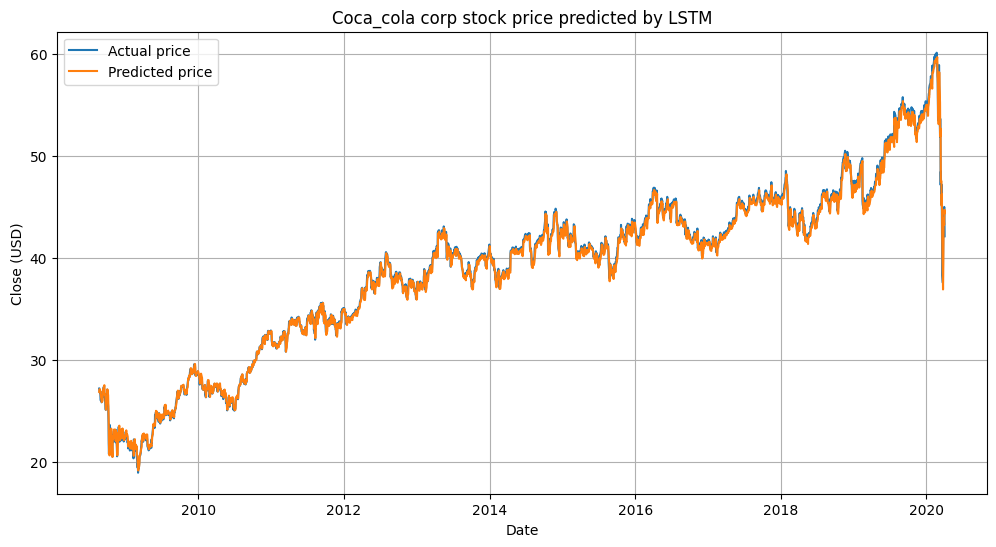

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual price')
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted price')
plt.title('Coca_cola corp stock price predicted by LSTM')
plt.xlabel('Date')
plt.ylabel('Close (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def process_stock(ticker, data_path="./data/stocks/{}.csv"):
    df = pd.read_csv(data_path.format(ticker), sep=',')
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df.fillna(method='ffill', inplace=True)

    df['EMA_12'] = talib.EMA(df['Close'], timeperiod=12)
    df['EMA_26'] = talib.EMA(df['Close'], timeperiod=26)
    features = ['Close', 'EMA_12', 'EMA_26']
    data = df[features].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    if np.any(np.isnan(scaled_data)):
        scaled_data = np.nan_to_num(scaled_data, nan=0.0)

    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)
    
    seq_length = 60
    X, y = create_sequences(scaled_data, seq_length)
    #print(f"Kích thước X cho {ticker}:", X.shape)

    train_size = int(len(X) * 0.6)
    val_size = int(len(X) * 0.2)

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

    #np.random.seed(42)
    #tf.random.set_seed(42)

    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(seq_length, len(features))),
        Dropout(0.1),
        #Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(len(features))  
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='mse', 
                metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                            patience=10,                              
                            restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val), 
                        epochs=200, batch_size=32, 
                        #shuffle=False, 
                        callbacks=[early_stop])
    
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test)

    if np.any(np.isnan(y_pred)) or np.any(np.isnan(y_test_actual)):
        #print(f"Dự đoán hoặc giá thực tế của {ticker} chứa NaN. Điền bằng 0.")
        y_pred = np.nan_to_num(y_pred, nan=0.0)
        y_test_actual = np.nan_to_num(y_test_actual, nan=0.0)

    rmse_close = root_mean_squared_error(y_test_actual[:, 0], y_pred[:, 0])
    rmse_ema12 = root_mean_squared_error(y_test_actual[:, 1], y_pred[:, 1])
    rmse_ema26 = root_mean_squared_error(y_test_actual[:, 2], y_pred[:, 2])
    print(f'RMSE cho {ticker} - Close: {rmse_close}')
    print(f'RMSE cho {ticker} - EMA_12: {rmse_ema12}')
    print(f'RMSE cho {ticker} - EMA_26: {rmse_ema26}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_actual[:, 0], label='Actual Close Price')
    plt.plot(df.index[-len(y_pred):], y_pred[:, 0], label='Predicted Close Price')
    plt.title(f'Predict {ticker} - Close')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_actual[:, 1], label='Actual EMA_12')
    plt.plot(df.index[-len(y_pred):], y_pred[:, 1], label='Predicted EMA_12')
    plt.title(f'Predict {ticker} - EMA_12')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_actual[:, 2], label='Actual EMA_26')
    plt.plot(df.index[-len(y_pred):], y_pred[:, 2], label='Predict EMA_26')
    plt.title(f'Predict {ticker} - EMA_26')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    return [rmse_close, rmse_ema12, rmse_ema26], history


Xử lý mã cổ phiếu: X
Epoch 1/200


C:\Users\Admin\AppData\Local\Temp\ipykernel_15828\1809343012.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0135 - mae: 0.0581 - val_loss: 3.0914e-04 - val_mae: 0.0091
Epoch 2/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.8710e-04 - mae: 0.0120 - val_loss: 2.5826e-04 - val_mae: 0.0087
Epoch 3/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.5237e-04 - mae: 0.0111 - val_loss: 2.1456e-04 - val_mae: 0.0075
Epoch 4/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.8667e-04 - mae: 0.0095 - val_loss: 1.6678e-04 - val_mae: 0.0071
Epoch 5/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.4663e-04 - mae: 0.0091 - val_loss: 1.8318e-04 - val_mae: 0.0084
Epoch 6/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.2568e-04 - mae: 0.0087 - val_loss: 1.5082e-04 - val_mae: 0.0077
Epoch 7/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.3587e-04 - mae: 0.0088 - val_loss: 1.3205e-04 - val_mae: 0.0072
Epoch 8/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.1701e-04 - mae: 0.0083 - val_loss: 1.2614e-04 - val_mae:

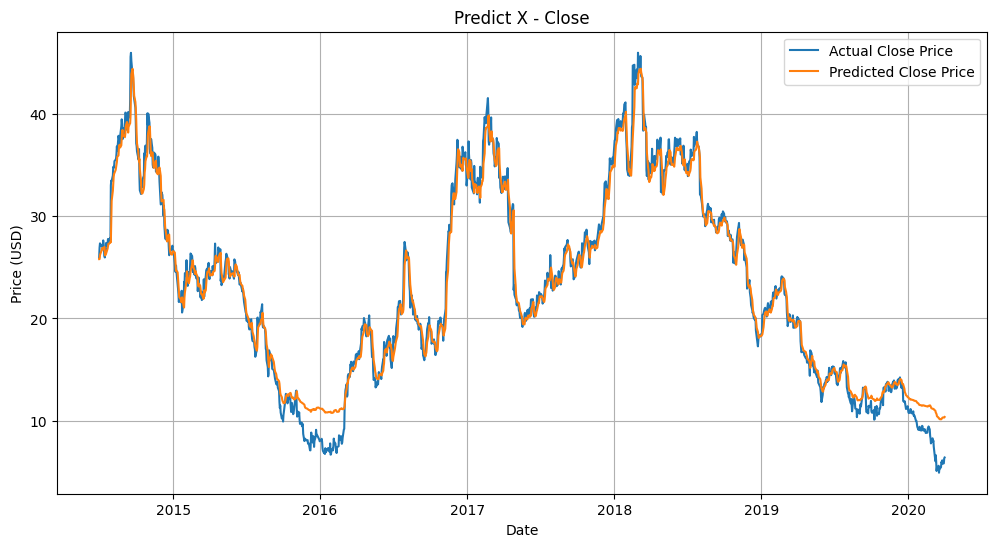

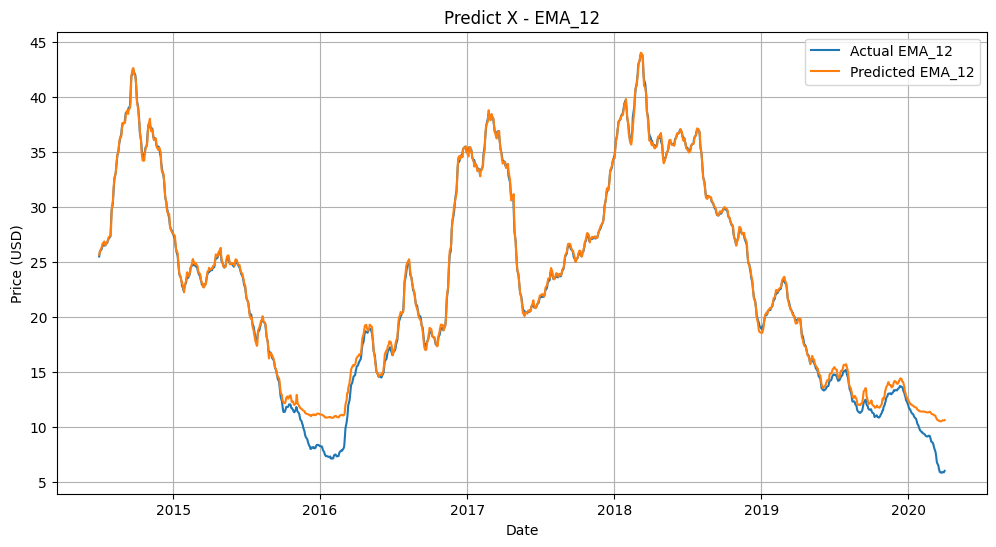

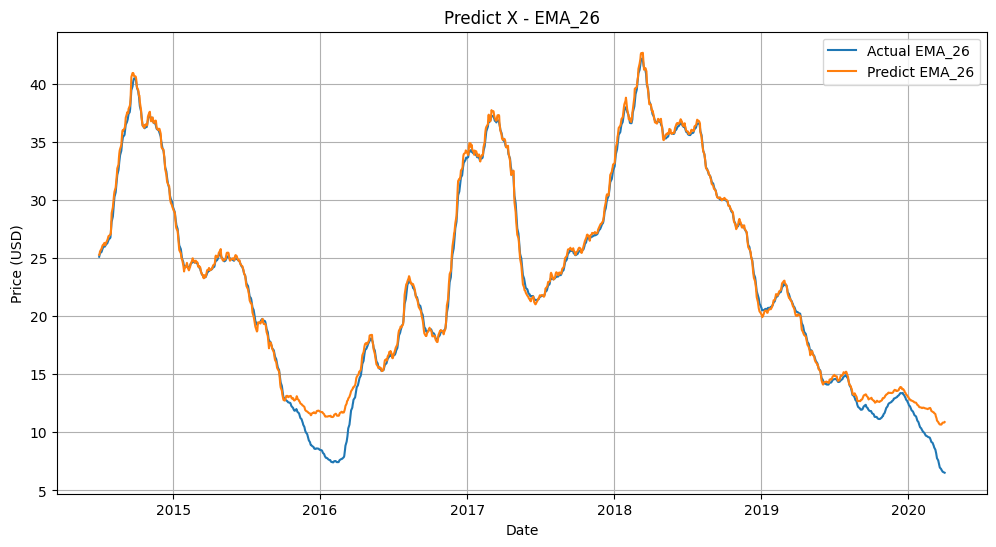


Xử lý mã cổ phiếu: KO
Epoch 1/200


C:\Users\Admin\AppData\Local\Temp\ipykernel_15828\1809343012.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 7.6821e-04 - mae: 0.0112 - val_loss: 3.3998e-04 - val_mae: 0.0152
Epoch 2/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.8728e-05 - mae: 0.0030 - val_loss: 4.2960e-04 - val_mae: 0.0180
Epoch 3/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 2.6990e-05 - mae: 0.0030 - val_loss: 1.4665e-04 - val_mae: 0.0091
Epoch 4/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 2.2107e-05 - mae: 0.0026 - val_loss: 2.5167e-04 - val_mae: 0.0139
Epoch 5/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 2.0962e-05 - mae: 0.0026 - val_loss: 2.1790e-04 - val_mae: 0.0119
Epoch 6/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.6735e-05 - mae: 0.0023 - val_loss: 3.1917e-04 - val_mae: 0.0149
Epoch 7/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.6807e-05 - mae: 0.0024 - val_loss: 3.1392e-04 - val_mae: 0.0130
Epoch 8/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.5999e-05 - mae: 0.0023 - val_loss: 1.0956e-04 - val_

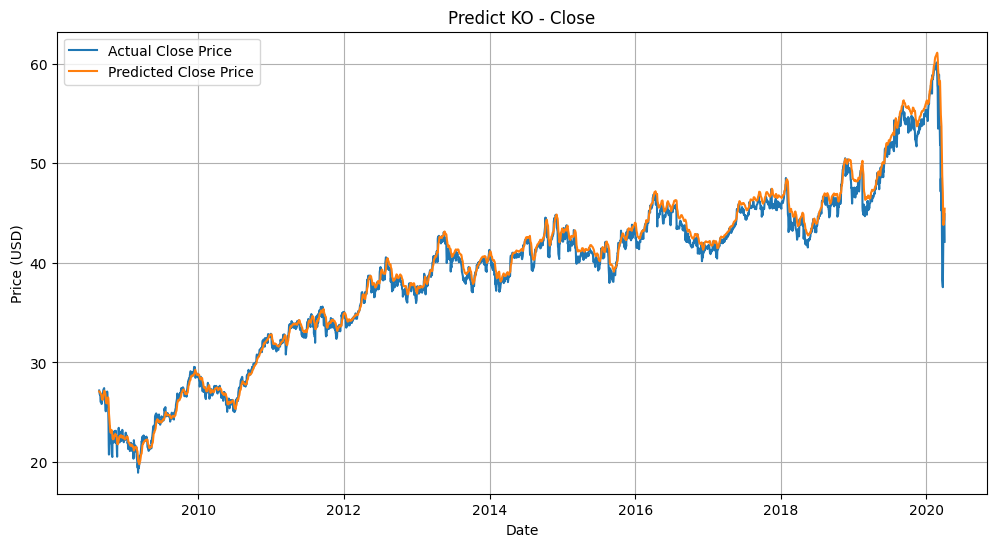

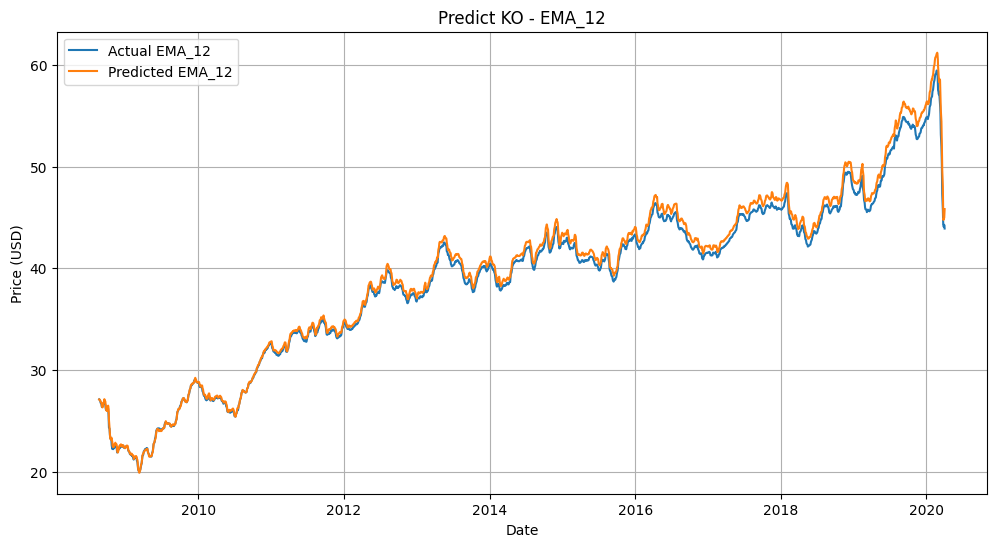

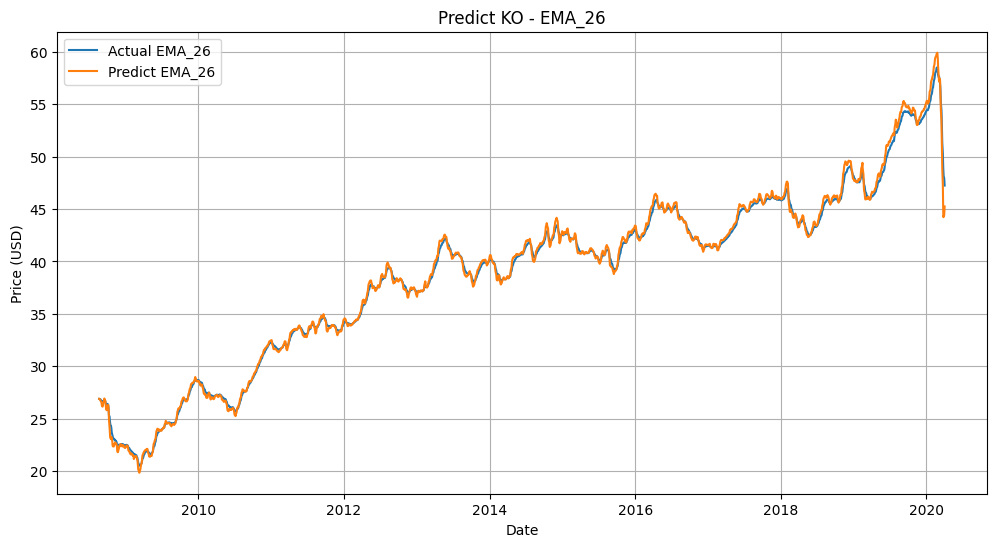


Xử lý mã cổ phiếu: INTL
Epoch 1/200


C:\Users\Admin\AppData\Local\Temp\ipykernel_15828\1809343012.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0072 - mae: 0.0409 - val_loss: 1.4439e-04 - val_mae: 0.0100
Epoch 2/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.4116e-04 - mae: 0.0104 - val_loss: 1.7883e-04 - val_mae: 0.0111
Epoch 3/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.7789e-04 - mae: 0.0090 - val_loss: 9.4455e-05 - val_mae: 0.0081
Epoch 4/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.3015e-04 - mae: 0.0083 - val_loss: 1.9427e-04 - val_mae: 0.0126
Epoch 5/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.9915e-04 - mae: 0.0077 - val_loss: 7.5055e-05 - val_mae: 0.0069
Epoch 6/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7399e-04 - mae: 0.0070 - val_loss: 4.8915e-05 - val_mae: 0.0047
Epoch 7/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.8895e-04 - mae: 0.0074 - val_loss: 8.9186e-05 - val_mae: 0.0082
Epoch 8/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.8162e-04 - mae: 0.0071 - val_loss: 3.8250e-05 - val_mae:

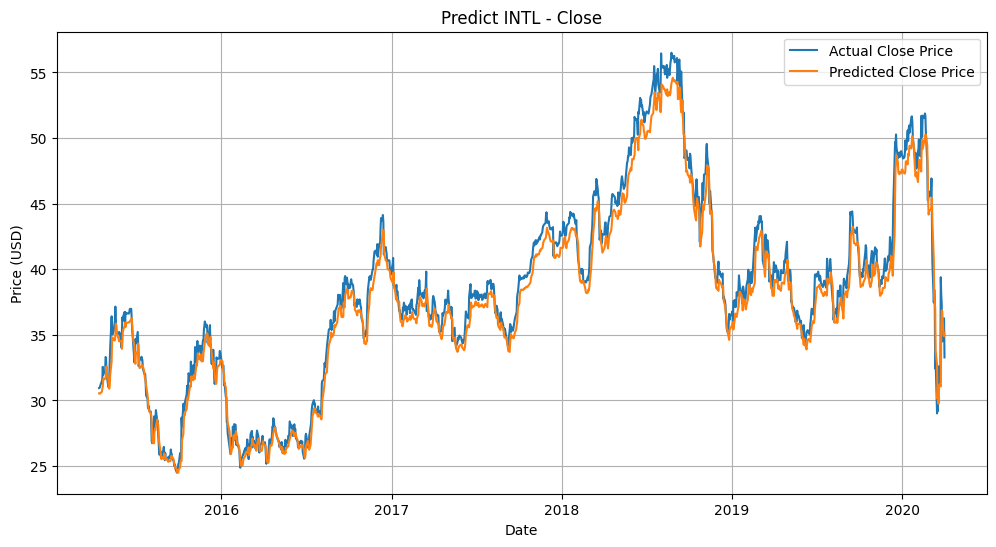

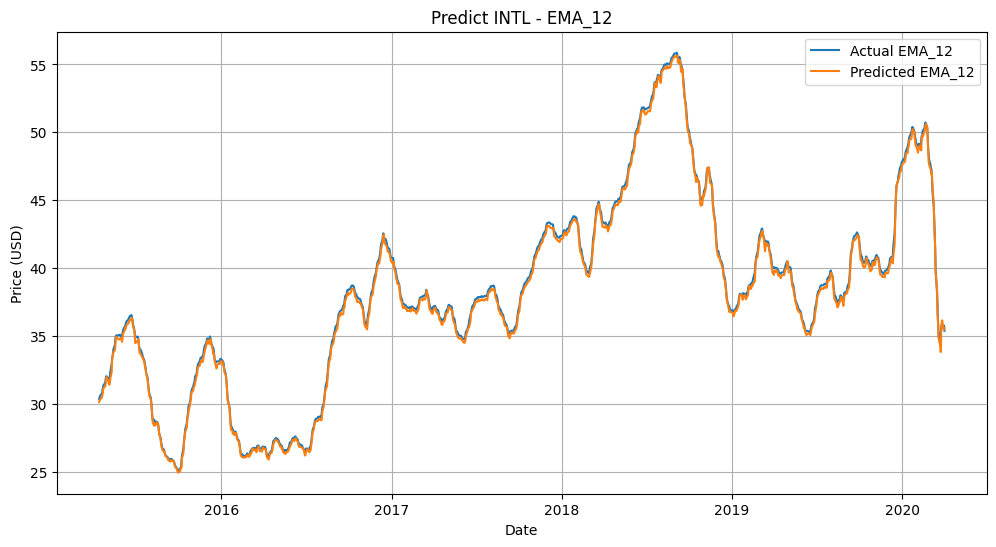

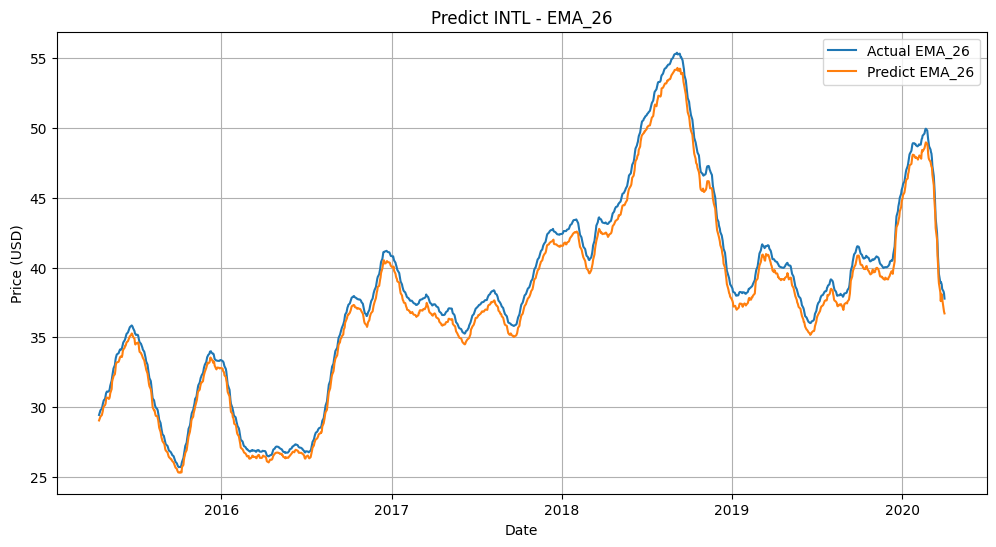

In [13]:
tickers = ['X', 'KO', 'INTL']
rmse_results = {}
for ticker in tickers:
    print(f"\nXử lý mã cổ phiếu: {ticker}")
    rmse, history = process_stock(ticker)
    rmse_results[ticker] = rmse

In [133]:
print("\nKết quả RMSE cho các mã cổ phiếu:")
for ticker, rmse in rmse_results.items():
    print(f"{ticker} - Close: {rmse[0]}")
    print(f"{ticker} - EMA_12: {rmse[1]}")
    print(f"{ticker} - EMA_26: {rmse[2]}")


Kết quả RMSE cho các mã cổ phiếu:
X - Close: 1.365414567501964
X - EMA_12: 0.9702870562959856
X - EMA_26: 1.1442839738326243
KO - Close: 0.8271551058658512
KO - EMA_12: 0.43299039924429633
KO - EMA_26: 0.43944830323060613
INTL - Close: 1.697541861547301
INTL - EMA_12: 0.4705704083805709
INTL - EMA_26: 0.7096954810207715
